<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/gula_pasir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7fa311a5b090>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.gula_pasir.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


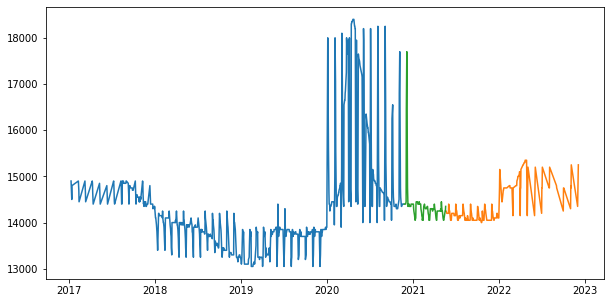

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

## model 

In [10]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


### SGD

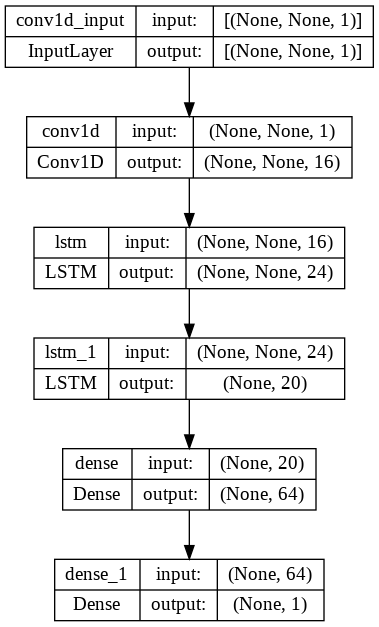

In [11]:
plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [12]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 19s 47ms/step - loss: 0.2420 - mae: 0.4144 - mape: 89.3869 - val_loss: 7.8078e-04 - val_mae: 0.0199 - val_mape: 6898486.0000
Epoch 2/30
44/44 [==============================] - 1s 21ms/step - loss: 0.1839 - mae: 0.3395 - mape: 68.0307 - val_loss: 0.0060 - val_mae: 0.0734 - val_mape: 13637411.0000
Epoch 3/30
44/44 [==============================] - 1s 21ms/step - loss: 0.1446 - mae: 0.2777 - mape: 50.4030 - val_loss: 0.0165 - val_mae: 0.1258 - val_mape: 19312452.0000
Epoch 4/30
44/44 [==============================] - 1s 26ms/step - loss: 0.1180 - mae: 0.2301 - mape: 37.6886 - val_loss: 0.0297 - val_mae: 0.1704 - val_mape: 24130096.0000
Epoch 5/30
44/44 [==============================] - 1s 31ms/step - loss: 0.0998 - mae: 0.2003 - mape: 31.1949 - val_loss: 0.0434 - val_mae: 0.2068 - val_mape: 28063914.0000
Epoch 6/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0880 - mae: 0.1918 - mape: 32.0976 - val_loss: 0.0575 - 

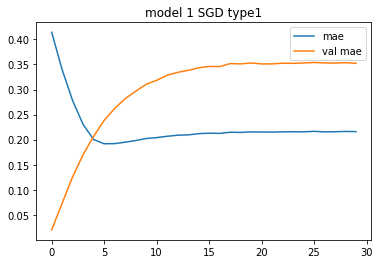

In [13]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

In [14]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
test_gulpas_ = scal_range.fit_transform(forecast.reshape(-1, 1))

131/131 [==============================] - 2s 8ms/step
957.74915 6.7345815 1025.7006751484566


,date,actual,prediction
0,2021-05-20,14250,15382.215820
1,2021-05-21,14250,15374.863281
2,2021-05-24,14200,15375.782227
3,2021-05-25,14200,15368.866211
4,2021-05-27,14200,15368.909180
...,...,...,...
229,2022-11-02,14800,15394.733398
230,2022-11-03,14750,15386.719727
231,2022-11-04,15250,15391.278320
232,2022-12-01,14350,15384.083984


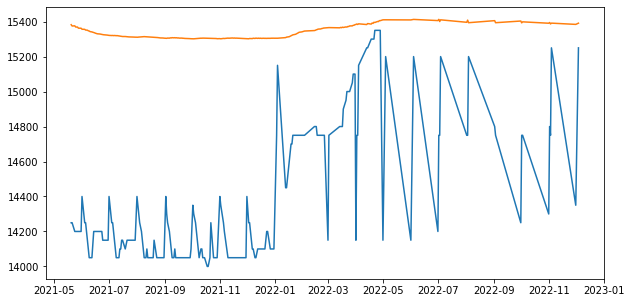

In [15]:
prediction = forecast_predict(model, test_gulpas_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_gulpas = pd.DataFrame()
data_new_gulpas['date'] = y_test
data_new_gulpas['actual'] = x_test
data_new_gulpas['prediction'] = data_result
data_new_gulpas.to_csv('gulpas_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_gulpas.date, data_new_gulpas.actual)
plt.plot(data_new_gulpas.date, data_new_gulpas.prediction)
data_new_gulpas

#### type2

In [16]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0432 - mae: 0.1438 - mape: 3103181.0000 - val_loss: 0.0617 - val_mae: 0.2471 - val_mape: 32444208.0000
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0362 - mae: 0.1182 - mape: 2611218.2500 - val_loss: 0.0550 - val_mae: 0.2331 - val_mape: 30945664.0000
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0345 - mae: 0.1162 - mape: 2397198.0000 - val_loss: 0.0495 - val_mae: 0.2210 - val_mape: 29646280.0000
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0319 - mae: 0.1104 - mape: 2507312.5000 - val_loss: 0.0421 - val_mae: 0.2034 - val_mape: 27766416.0000
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0283 - mae: 0.1047 - mape: 1927986.1250 - val_loss: 0.0415 - val_mae: 0.2021 - val_mape: 27634044.0000
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0267 - mae: 0.1035 - mape: 20

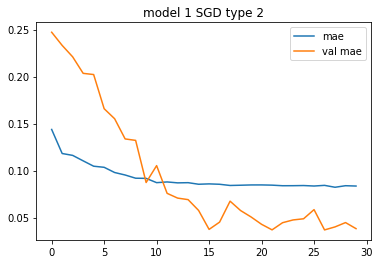

In [17]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
216.28929 1.4962084 277.45337446136784


,date,actual,prediction
0,2021-05-20,14250,15382.215820
1,2021-05-21,14250,15374.863281
2,2021-05-24,14200,15375.782227
3,2021-05-25,14200,15368.866211
4,2021-05-27,14200,15368.909180
...,...,...,...
229,2022-11-02,14800,15394.733398
230,2022-11-03,14750,15386.719727
231,2022-11-04,15250,15391.278320
232,2022-12-01,14350,15384.083984


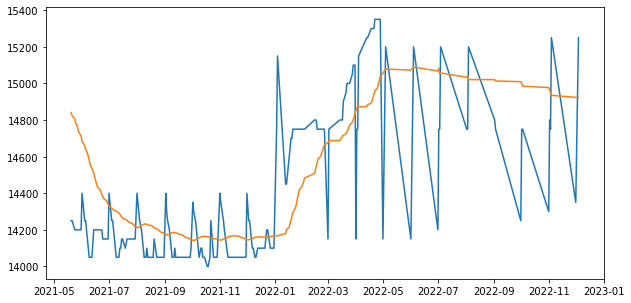

In [18]:
win_size1 = 60
test_gulpas_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_gulpas_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_gulpas_1 = pd.DataFrame()
data_new_gulpas_1['actual'] = x_test
data_new_gulpas_1['prediction'] = data_result_1
data_new_gulpas_1.to_csv('gulpas_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas_1.actual)
plt.plot(y_test, data_new_gulpas_1.prediction)
data_new_gulpas

#### type3

In [19]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 2s 17ms/step - loss: 0.0304 - mae: 0.1085 - mape: 1860450.0000 - val_loss: 0.0027 - val_mae: 0.0455 - val_mape: 10642464.0000
Epoch 2/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0303 - mae: 0.1105 - mape: 2058168.5000 - val_loss: 0.0025 - val_mae: 0.0433 - val_mape: 10386961.0000
Epoch 3/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0302 - mae: 0.1106 - mape: 2056329.0000 - val_loss: 0.0029 - val_mae: 0.0473 - val_mape: 10853055.0000
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0302 - mae: 0.1095 - mape: 1995381.3750 - val_loss: 0.0028 - val_mae: 0.0468 - val_mape: 10787518.0000
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0301 - mae: 0.1101 - mape: 2011783.7500 - val_loss: 0.0030 - val_mae: 0.0485 - val_mape: 10992040.0000
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0301 - mae: 0.1111 - mape: 2060981.

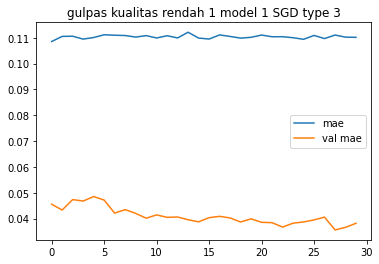

In [20]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('gulpas kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
249.47179 1.7412622 315.5487284081494


,actual,prediction
0,14250,14969.971680
1,14250,14951.332031
2,14200,14932.942383
3,14200,14910.677734
4,14200,14888.612305
...,...,...
229,14800,15091.521484
230,14750,15074.832031
231,15250,15062.584961
232,14350,15050.619141


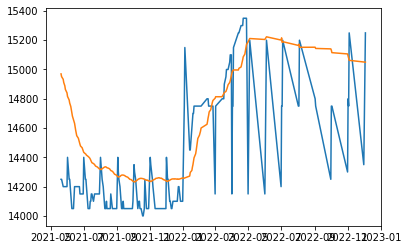

In [21]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_gulpas_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_gulpas_2 = pd.DataFrame()
# data_new_gulpas1['date'] = date_test
data_new_gulpas_2['actual'] = x_test
data_new_gulpas_2['prediction'] = data_result_2
data_new_gulpas_2.to_csv('gulpas_model1_sgd_type3')

plt.plot(y_test, data_new_gulpas_2.actual)
plt.plot(y_test, data_new_gulpas_2.prediction)
data_new_gulpas_2

### Adam

In [22]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [23]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 4s 38ms/step - loss: 0.2154 - mae: 0.3847 - mape: 81.6108 - val_loss: 7.4474e-04 - val_mae: 0.0227 - val_mape: 4866171.0000
Epoch 2/30
44/44 [==============================] - 1s 20ms/step - loss: 0.1407 - mae: 0.2755 - mape: 51.2099 - val_loss: 0.0027 - val_mae: 0.0459 - val_mape: 10696925.0000
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0807 - mae: 0.1886 - mape: 33.5778 - val_loss: 0.0132 - val_mae: 0.1120 - val_mape: 17956484.0000
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0591 - mae: 0.1957 - mape: 47.9600 - val_loss: 0.0195 - val_mae: 0.1372 - val_mape: 20716588.0000
Epoch 5/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0553 - mae: 0.1912 - mape: 47.8395 - val_loss: 0.0178 - val_mae: 0.1308 - val_mape: 20026708.0000
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0557 - mae: 0.1918 - mape: 48.3795 - val_loss: 0.0162 - v

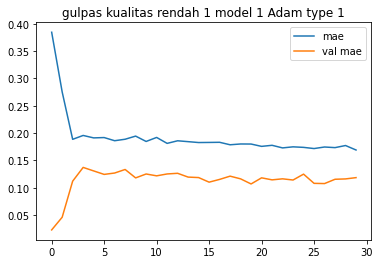

In [24]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('gulpas kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
375.0529 2.6339986 429.1601354681024


,actual,prediction
0,14250,15004.585938
1,14250,14954.184570
2,14200,14962.521484
3,14200,14910.767578
4,14200,14908.427734
...,...,...
229,14800,15124.114258
230,14750,15059.478516
231,15250,15071.122070
232,14350,15019.023438


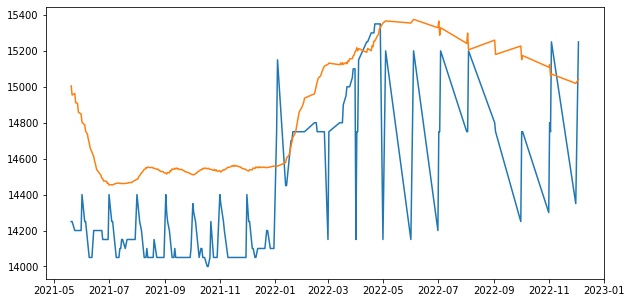

In [25]:
prediction_a = forecast_predict(model_a, test_gulpas_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_gulpas_a = pd.DataFrame()
# data_new_gulpas1['date'] = date_test
data_new_gulpas_a['actual'] = x_test
data_new_gulpas_a['prediction'] = data_result_a
data_new_gulpas_a.to_csv('gulpas_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_gulpas_a.actual)
plt.plot(y_test, data_new_gulpas_a.prediction)
data_new_gulpas_a

#### Type 2

In [26]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0189 - mae: 0.0829 - mape: 1841961.0000 - val_loss: 0.0082 - val_mae: 0.0862 - val_mape: 15405596.0000
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0176 - mae: 0.0764 - mape: 1738264.3750 - val_loss: 0.0067 - val_mae: 0.0771 - val_mape: 14437613.0000
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0176 - mae: 0.0787 - mape: 1420779.3750 - val_loss: 0.0023 - val_mae: 0.0410 - val_mape: 10398448.0000
Epoch 4/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0174 - mae: 0.0769 - mape: 1475201.7500 - val_loss: 0.0013 - val_mae: 0.0276 - val_mape: 8598065.0000
Epoch 5/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0169 - mae: 0.0749 - mape: 1462199.2500 - val_loss: 0.0051 - val_mae: 0.0655 - val_mape: 13193270.0000
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0171 - mae: 0.0764 - mape: 148

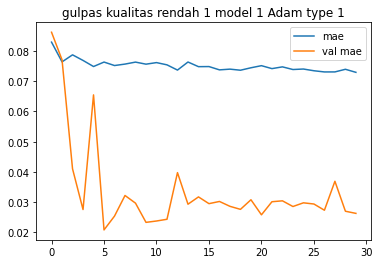

In [27]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('gulpas kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 6ms/step
365.34644 2.5422528 523.3135412924072


,actual,prediction
0,14250,15460.682617
1,14250,15433.446289
2,14200,15436.362305
3,14200,15402.783203
4,14200,15398.923828
...,...,...
229,14800,15855.255859
230,14750,15794.532227
231,15250,15830.519531
232,14350,15771.553711


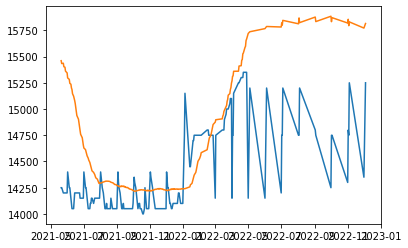

In [28]:
prediction_a1 = forecast_predict(model_a, test_gulpas_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_gulpas_a1 = pd.DataFrame()
data_new_gulpas_a1['actual'] = x_test
data_new_gulpas_a1['prediction'] = data_result_a1
data_new_gulpas_a1.to_csv('gulpas_model1_adam_type2.csv')

plt.plot(y_test, data_new_gulpas_a1.actual)
plt.plot(y_test, data_new_gulpas_a1.prediction)
data_new_gulpas_a1

#### Type 3

In [29]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 2s 16ms/step - loss: 0.0242 - mae: 0.0955 - mape: 1915127.8750 - val_loss: 0.0013 - val_mae: 0.0282 - val_mape: 8534153.0000
Epoch 2/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0241 - mae: 0.0957 - mape: 1941551.8750 - val_loss: 0.0012 - val_mae: 0.0270 - val_mape: 8346830.5000
Epoch 3/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0240 - mae: 0.0963 - mape: 1915351.7500 - val_loss: 0.0012 - val_mae: 0.0270 - val_mape: 8344875.0000
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0240 - mae: 0.0952 - mape: 1922020.7500 - val_loss: 0.0012 - val_mae: 0.0273 - val_mape: 8404511.0000
Epoch 5/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0241 - mae: 0.0955 - mape: 1911632.1250 - val_loss: 0.0011 - val_mae: 0.0258 - val_mape: 8117768.0000
Epoch 6/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0241 - mae: 0.0949 - mape: 1923784.8750 

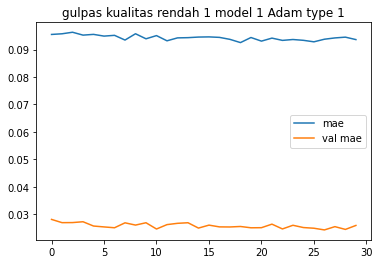

In [30]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('gulpas kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
327.49594 2.2489927 513.6553440781084


,actual,prediction
0,14250,14639.138672
1,14250,14629.879883
2,14200,14632.747070
3,14200,14621.103516
4,14200,14624.213867
...,...,...
229,14800,15903.269531
230,14750,15785.258789
231,15250,15781.300781
232,14350,15670.360352


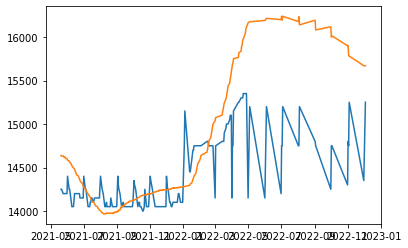

In [31]:
prediction_a2 = forecast_predict(model_a, test_gulpas_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_gulpas_a2 = pd.DataFrame()
# data_new_gulpas1['date'] = date_test
data_new_gulpas_a2['actual'] = x_test
data_new_gulpas_a2['prediction'] = data_result_a2
data_new_gulpas_a2.to_csv('gulpas_model1_adam_type3.csv')

plt.plot(y_test, data_new_gulpas_a2.actual)
plt.plot(y_test, data_new_gulpas_a2.prediction)
data_new_gulpas_a2

## model 1

### Adam

In [32]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
        LSTM(128, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [33]:
history1 = model1.fit(train_step, epochs=100, validation_data=val_step)

Epoch 1/100
44/44 [==============================] - 5s 43ms/step - loss: 0.0820 - mae: 0.2201 - mape: 53.0509 - val_loss: 0.0115 - val_mae: 0.1038 - val_mape: 17060150.0000
Epoch 2/100
44/44 [==============================] - 1s 22ms/step - loss: 0.0563 - mae: 0.1930 - mape: 48.1393 - val_loss: 0.0118 - val_mae: 0.1052 - val_mape: 17267294.0000
Epoch 3/100
44/44 [==============================] - 1s 22ms/step - loss: 0.0566 - mae: 0.1818 - mape: 44.8676 - val_loss: 0.0155 - val_mae: 0.1218 - val_mape: 19044210.0000
Epoch 4/100
44/44 [==============================] - 1s 22ms/step - loss: 0.0564 - mae: 0.1774 - mape: 43.6414 - val_loss: 0.0189 - val_mae: 0.1349 - val_mape: 20405960.0000
Epoch 5/100
44/44 [==============================] - 1s 22ms/step - loss: 0.0525 - mae: 0.1853 - mape: 46.8710 - val_loss: 0.0112 - val_mae: 0.1027 - val_mape: 16862820.0000
Epoch 6/100
44/44 [==============================] - 1s 22ms/step - loss: 0.0609 - mae: 0.1914 - mape: 48.3908 - val_loss: 0.0119 

17/17 [==============================] - 0s 7ms/step - loss: 0.0945 - mae: 0.2611 - mape: 78.0221


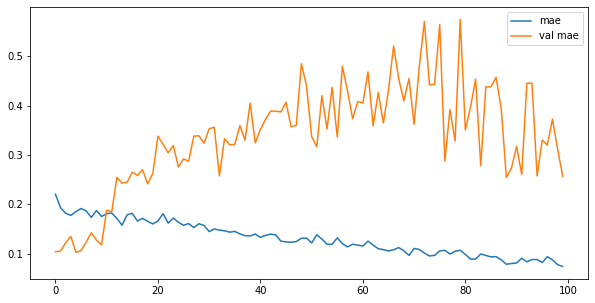

In [34]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [35]:
prediction1 = forecast_predict(model1, test_gulpas_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_gulpas1 = pd.DataFrame()
data_new_gulpas1['actual'] = x_test
data_new_gulpas1['prediction'] = data_result1
data_new_gulpas1.to_csv('gulpas_model2_adam_type1.csv')

data_new_gulpas1

131/131 [==============================] - 2s 8ms/step
507.43002 3.537723 601.7220080734957


,actual,prediction
0,14250,14342.447266
1,14250,14361.587891
2,14200,14310.702148
3,14200,14303.887695
4,14200,14329.029297
...,...,...
229,14800,14996.746094
230,14750,15805.709961
231,15250,15138.614258
232,14350,15829.400391


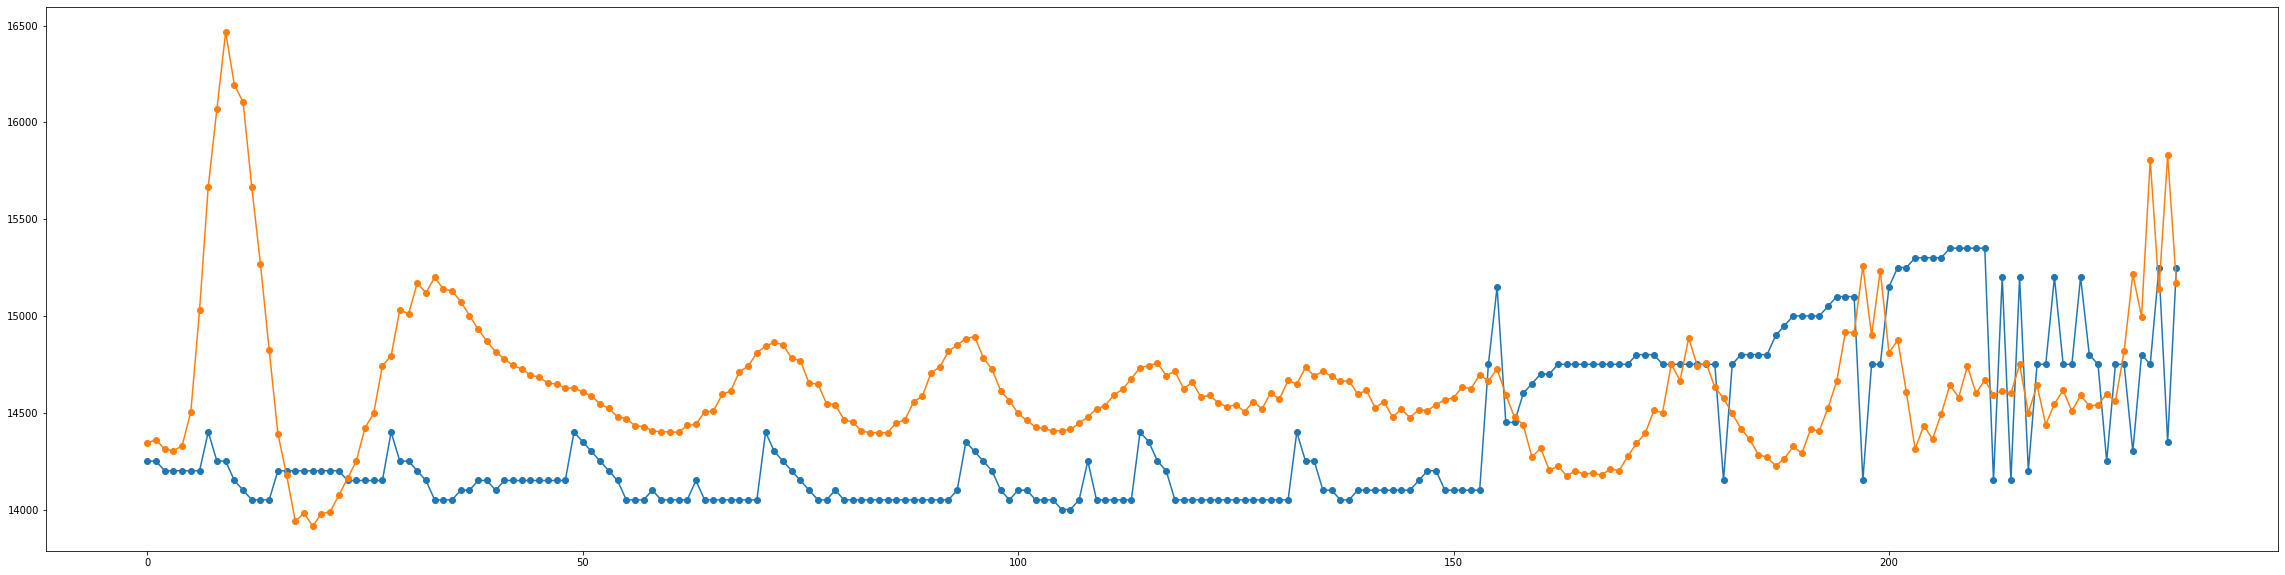

In [36]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_gulpas1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_gulpas1['prediction'], '-o')

#### Type 2

In [37]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0300 - mae: 0.1043 - mape: 1905831.8750 - val_loss: 0.0970 - val_mae: 0.3104 - val_mape: 39244248.0000
Epoch 2/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0319 - mae: 0.1131 - mape: 2056679.8750 - val_loss: 0.0978 - val_mae: 0.3117 - val_mape: 39378880.0000
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0322 - mae: 0.1151 - mape: 2066555.1250 - val_loss: 0.0809 - val_mae: 0.2833 - val_mape: 36312652.0000
Epoch 4/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0305 - mae: 0.1137 - mape: 1712883.7500 - val_loss: 0.0961 - val_mae: 0.3089 - val_mape: 39078592.0000
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0320 - mae: 0.1148 - mape: 2385977.0000 - val_loss: 0.1115 - val_mae: 0.3329 - val_mape: 41675020.0000
Epoch 6/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0325 - mae: 0.1154 - mape: 2

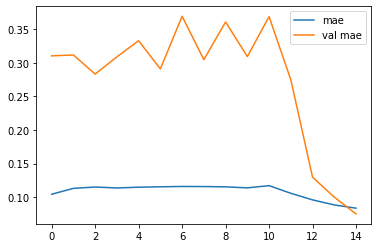

In [38]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
394.20816 2.768011 601.7220080734957


,actual,prediction
0,14250,14741.540039
1,14250,14735.748047
2,14200,14727.561523
3,14200,14719.127930
4,14200,14708.493164
...,...,...
229,14800,14814.136719
230,14750,14794.024414
231,15250,14793.403320
232,14350,14801.769531


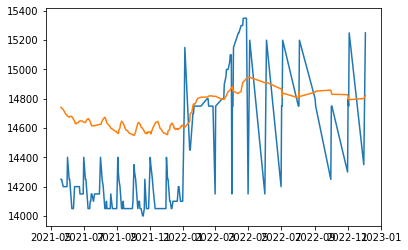

In [39]:
prediction1_1 = forecast_predict(model1, test_gulpas_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_gulpas1_1 = pd.DataFrame()
data_new_gulpas1_1['actual'] = x_test
data_new_gulpas1_1['prediction'] = data_result1_1
data_new_gulpas1_1.to_csv('gulpas_model2_adam_type2.csv')

plt.plot(y_test, data_new_gulpas1_1.actual)
plt.plot(y_test, data_new_gulpas1_1.prediction)
data_new_gulpas1_1

#### Type 3

In [40]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 19ms/step - loss: 0.0298 - mae: 0.1093 - mape: 2029938.1250 - val_loss: 0.0032 - val_mae: 0.0511 - val_mape: 11203529.0000
Epoch 2/15
84/84 [==============================] - 2s 16ms/step - loss: 0.0285 - mae: 0.1122 - mape: 1805088.5000 - val_loss: 0.0044 - val_mae: 0.0614 - val_mape: 12369343.0000
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0283 - mae: 0.1075 - mape: 1797238.3750 - val_loss: 0.0057 - val_mae: 0.0712 - val_mape: 13437590.0000
Epoch 4/15
84/84 [==============================] - 2s 16ms/step - loss: 0.0268 - mae: 0.1036 - mape: 1919142.3750 - val_loss: 0.0032 - val_mae: 0.0503 - val_mape: 11111152.0000
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0261 - mae: 0.0985 - mape: 1834368.2500 - val_loss: 0.0032 - val_mae: 0.0508 - val_mape: 11170960.0000
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0274 - mae: 0.1046 - mape: 1789545.

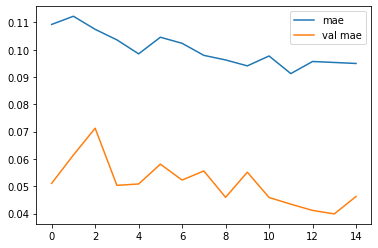

In [41]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
507.78693 3.5756602 601.7220080734957


,actual,prediction
0,14250,15112.876953
1,14250,15076.567383
2,14200,15062.177734
3,14200,15060.722656
4,14200,15082.100586
...,...,...
229,14800,15028.641602
230,14750,14821.845703
231,15250,14936.650391
232,14350,14893.966797


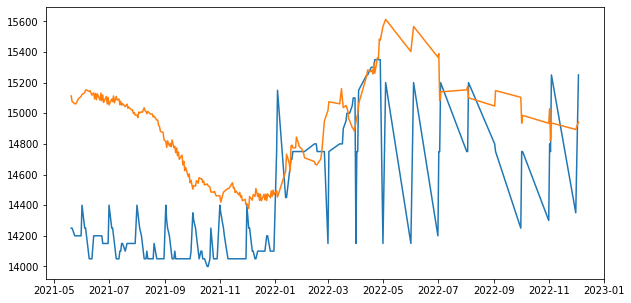

In [42]:
prediction1_2 = forecast_predict(model1, test_gulpas_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_gulpas1_2 = pd.DataFrame()
data_new_gulpas1_2['actual'] = x_test
data_new_gulpas1_2['prediction'] = data_result1_2
data_new_gulpas1_2.to_csv('gulpas_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas1_2.actual)
plt.plot(y_test, data_new_gulpas1_2.prediction)

data_new_gulpas1_2

### SGD

In [43]:
model1_a= Sequential([
    # tf.keras.layers.Conv1D(97, kernel_size=5, 
    #                                        activation='relu',strides=2,
    #                                        input_shape=[None, 1]),
    #                 LSTM(24, return_sequences=True),
    #                 LSTM(64),
    #                 Dense(50, activation='relu'),
    #                 Dense(12, activation='relu'),
    #                 Dense(1)
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
        LSTM(128, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.8), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [44]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [45]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 45ms/step - loss: 0.2621 - mae: 0.4381 - mape: 96.2117 - val_loss: 8.2423e-04 - val_mae: 0.0250 - val_mape: 4313685.5000
Epoch 2/15
44/44 [==============================] - 1s 23ms/step - loss: 0.2181 - mae: 0.3857 - mape: 81.2118 - val_loss: 0.0011 - val_mae: 0.0259 - val_mape: 8026555.0000
Epoch 3/15
44/44 [==============================] - 1s 23ms/step - loss: 0.1870 - mae: 0.3440 - mape: 69.2798 - val_loss: 0.0034 - val_mae: 0.0527 - val_mape: 11380752.0000
Epoch 4/15
44/44 [==============================] - 1s 22ms/step - loss: 0.1628 - mae: 0.3080 - mape: 58.9314 - val_loss: 0.0072 - val_mae: 0.0810 - val_mape: 14478674.0000
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.1430 - mae: 0.2753 - mape: 49.6718 - val_loss: 0.0122 - val_mae: 0.1072 - val_mape: 17314822.0000
Epoch 6/15
44/44 [==============================] - 1s 23ms/step - loss: 0.1270 - mae: 0.2470 - mape: 42.0941 - val_loss: 0.0181 - va

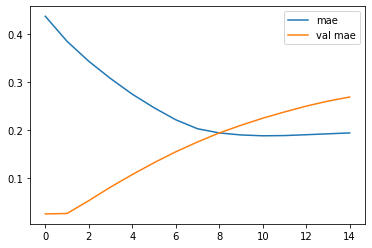

In [46]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 1s 8ms/step
509.3586 3.5867672 609.99741290435


,actual,prediction
0,14250,15119.412109
1,14250,15079.181641
2,14200,15065.861328
3,14200,15064.207031
4,14200,15085.385742
...,...,...
229,14800,15029.917969
230,14750,14823.057617
231,15250,14938.315430
232,14350,14894.853516


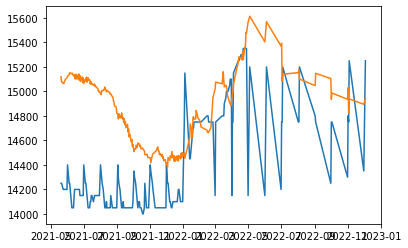

In [47]:
prediction1_a = forecast_predict(model1, test_gulpas_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_gulpas1_a = pd.DataFrame()
data_new_gulpas1_a['actual'] = x_test
data_new_gulpas1_a['prediction'] = data_result1_a
data_new_gulpas1_a.to_csv('gulpas_model2_sgd_type1.csv')


plt.plot(y_test, data_new_gulpas1_a.actual)
plt.plot(y_test, data_new_gulpas1_a.prediction)

data_new_gulpas1_a

#### Type 2


In [48]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0407 - mae: 0.1395 - mape: 3300113.5000 - val_loss: 0.0387 - val_mae: 0.1950 - val_mape: 26822224.0000
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0350 - mae: 0.1150 - mape: 2660029.7500 - val_loss: 0.0348 - val_mae: 0.1847 - val_mape: 25718776.0000
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0331 - mae: 0.1102 - mape: 2675496.2500 - val_loss: 0.0323 - val_mae: 0.1780 - val_mape: 24990816.0000
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0318 - mae: 0.1070 - mape: 2725740.7500 - val_loss: 0.0300 - val_mae: 0.1713 - val_mape: 24269958.0000
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0305 - mae: 0.1040 - mape: 2499214.5000 - val_loss: 0.0270 - val_mae: 0.1624 - val_mape: 23312634.0000
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0291 - mae: 0.1029 - mape: 25

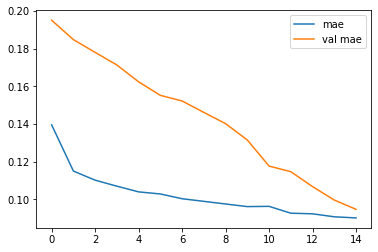

In [49]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
298.10992 2.0793743 334.6653645808003


,actual,prediction
0,14250,14874.308594
1,14250,14848.642578
2,14200,14853.255859
3,14200,14827.203125
4,14200,14827.273438
...,...,...
229,14800,14956.464844
230,14750,14919.159180
231,15250,14937.197266
232,14350,14904.817383


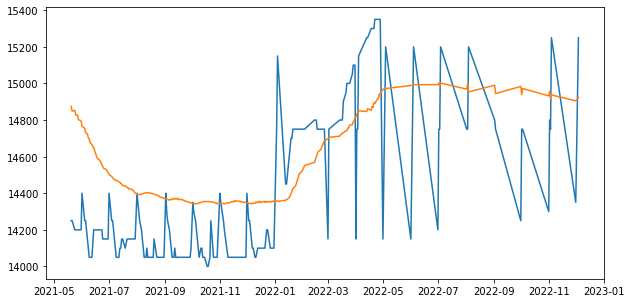

In [50]:
prediction1_a1 = forecast_predict(model1_a, test_gulpas_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_gulpas1_a1 = pd.DataFrame()
data_new_gulpas1_a1['actual'] = x_test
data_new_gulpas1_a1['prediction'] = data_result1_a1
data_new_gulpas1_a1.to_csv('gulpas_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas1_a1.actual)
plt.plot(y_test, data_new_gulpas1_a1.prediction)
data_new_gulpas1_a1

#### Type 3

In [51]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 19ms/step - loss: 0.0341 - mae: 0.1263 - mape: 2661684.2500 - val_loss: 0.0093 - val_mae: 0.0931 - val_mape: 15842269.0000
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0339 - mae: 0.1244 - mape: 2604400.5000 - val_loss: 0.0091 - val_mae: 0.0916 - val_mape: 15676300.0000
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0338 - mae: 0.1241 - mape: 2606060.5000 - val_loss: 0.0084 - val_mae: 0.0879 - val_mape: 15273991.0000
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0337 - mae: 0.1226 - mape: 2557142.2500 - val_loss: 0.0081 - val_mae: 0.0863 - val_mape: 15103867.0000
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0336 - mae: 0.1219 - mape: 2533668.0000 - val_loss: 0.0079 - val_mae: 0.0853 - val_mape: 14991498.0000
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0335 - mae: 0.1215 - mape: 2486729.

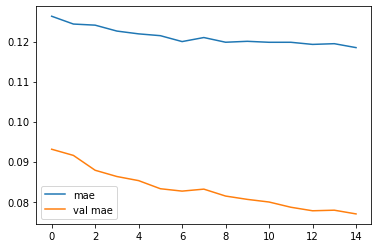

In [52]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 6ms/step
282.16995 1.9650159 324.36608850957276


,actual,prediction
0,14250,14905.047852
1,14250,14876.257812
2,14200,14880.907227
3,14200,14851.344727
4,14200,14851.160156
...,...,...
229,14800,14992.507812
230,14750,14949.001953
231,15250,14971.226562
232,14350,14932.696289


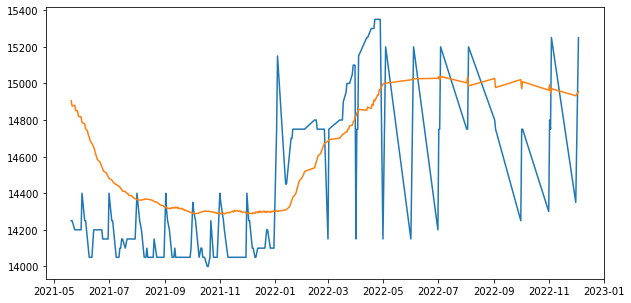

In [53]:
prediction1_a2 = forecast_predict(model1_a, test_gulpas_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_gulpas1_a2 = pd.DataFrame()
data_new_gulpas1_a2['actual'] = x_test
data_new_gulpas1_a2['prediction'] = data_result1_a2
data_new_gulpas1_a2.to_csv('gulpas_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas1_a2.actual)
plt.plot(y_test, data_new_gulpas1_a2.prediction)

data_new_gulpas1_a2

## model 2

### SGD

In [54]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9), loss='mean_squared_error', metrics=['mae'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [55]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [56]:
history2 = model2.fit(train_step, epochs=100, validation_data=val_step)

Epoch 1/100
44/44 [==============================] - 4s 34ms/step - loss: 0.2949 - mae: 0.4753 - val_loss: 0.0038 - val_mae: 0.0564
Epoch 2/100
44/44 [==============================] - 1s 15ms/step - loss: 0.2952 - mae: 0.4756 - val_loss: 0.0038 - val_mae: 0.0563
Epoch 3/100
44/44 [==============================] - 1s 14ms/step - loss: 0.2953 - mae: 0.4757 - val_loss: 0.0038 - val_mae: 0.0562
Epoch 4/100
44/44 [==============================] - 1s 14ms/step - loss: 0.2951 - mae: 0.4755 - val_loss: 0.0038 - val_mae: 0.0561
Epoch 5/100
44/44 [==============================] - 1s 15ms/step - loss: 0.2948 - mae: 0.4752 - val_loss: 0.0038 - val_mae: 0.0560
Epoch 6/100
44/44 [==============================] - 1s 15ms/step - loss: 0.2942 - mae: 0.4747 - val_loss: 0.0038 - val_mae: 0.0559
Epoch 7/100
44/44 [==============================] - 1s 14ms/step - loss: 0.2946 - mae: 0.4748 - val_loss: 0.0038 - val_mae: 0.0558
Epoch 8/100
44/44 [==============================] - 1s 14ms/step - loss: 0.

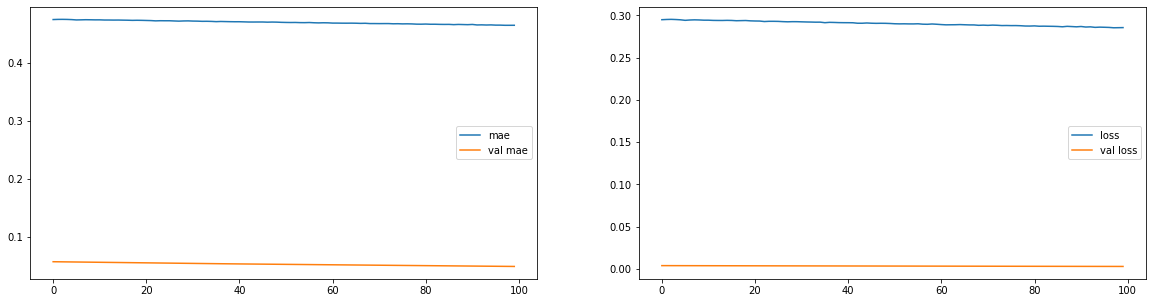

In [57]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
1348.9307 9.3161955 1406.928658461402


,actual,prediction
0,14250,12991.548828
1,14250,12990.168945
2,14200,12994.279297
3,14200,12995.942383
4,14200,12994.403320
...,...,...
229,14800,12999.635742
230,14750,12999.222656
231,15250,12998.598633
232,14350,13000.077148


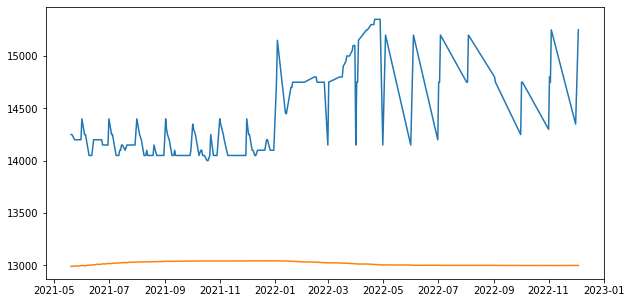

In [58]:
prediction2 = forecast_predict(model2, test_gulpas_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_gulpas2 = pd.DataFrame()
data_new_gulpas2['actual'] = x_test
data_new_gulpas2['prediction'] = data_result2
data_new_gulpas2.to_csv('gulpas_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas2.actual)
plt.plot(y_test, data_new_gulpas2.prediction)
data_new_gulpas2

#### Type2

In [59]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0987 - mae: 0.2231 - val_loss: 0.0028 - val_mae: 0.0476
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0983 - mae: 0.2223 - val_loss: 0.0027 - val_mae: 0.0471
Epoch 3/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0980 - mae: 0.2217 - val_loss: 0.0027 - val_mae: 0.0465
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0977 - mae: 0.2210 - val_loss: 0.0026 - val_mae: 0.0460
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0974 - mae: 0.2202 - val_loss: 0.0025 - val_mae: 0.0454
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0971 - mae: 0.2197 - val_loss: 0.0025 - val_mae: 0.0448
Epoch 7/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0967 - mae: 0.2188 - val_loss: 0.0024 - val_mae: 0.0443
Epoch 8/50
718/718 [==============================] - 5s 8ms/step - loss: 0.

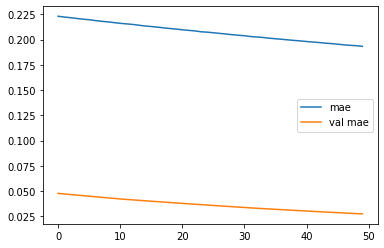

In [60]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [61]:
prediction2_1 = forecast_predict(model2, test_gulpas_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_gulpas2_1 = pd.DataFrame()
data_new_gulpas2_1['actual'] = x_test
data_new_gulpas2_1['prediction'] = data_result2_1
data_new_gulpas2_1.to_csv('gulpas_model3_sgd_type2.csv')

data_new_gulpas2

199/199 [==============================] - 1s 4ms/step
1159.3705 7.9965696 1226.4908784821841


,actual,prediction
0,14250,12991.548828
1,14250,12990.168945
2,14200,12994.279297
3,14200,12995.942383
4,14200,12994.403320
...,...,...
229,14800,12999.635742
230,14750,12999.222656
231,15250,12998.598633
232,14350,13000.077148


#### Type 3

In [62]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.1366 - mae: 0.2642 - val_loss: 9.3020e-04 - val_mae: 0.0272
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.1364 - mae: 0.2640 - val_loss: 9.2751e-04 - val_mae: 0.0272
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1363 - mae: 0.2639 - val_loss: 9.2492e-04 - val_mae: 0.0271
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1364 - mae: 0.2639 - val_loss: 9.2232e-04 - val_mae: 0.0271
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.1363 - mae: 0.2637 - val_loss: 9.1974e-04 - val_mae: 0.0270
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.1362 - mae: 0.2637 - val_loss: 9.1711e-04 - val_mae: 0.0270
Epoch 7/50
84/84 [==============================] - 2s 17ms/step - loss: 0.1363 - mae: 0.2637 - val_loss: 9.1452e-04 - val_mae: 0.0270
Epoch 8/50
84/84 [==============================] - 1s 

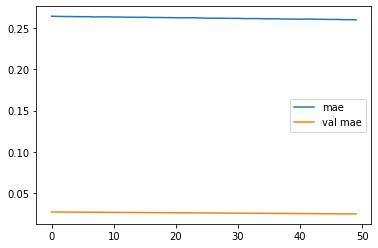

In [63]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [64]:
prediction2_2 = forecast_predict(model2, test_gulpas_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_gulpas2_2 = pd.DataFrame()
data_new_gulpas2_2['actual'] = x_test
data_new_gulpas2_2['prediction'] = data_result2_2
data_new_gulpas2_2.to_csv('gulpas_model3_sgd-type3.csv')

data_new_gulpas2_2

181/181 [==============================] - 1s 4ms/step
1138.8612 7.854047 1206.6969379260063


,actual,prediction
0,14250,13208.399414
1,14250,13209.761719
2,14200,13208.390625
3,14200,13207.263672
4,14200,13211.109375
...,...,...
229,14800,13213.188477
230,14750,13214.821289
231,15250,13214.208984
232,14350,13213.649414


### Adam

In [65]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [66]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 35ms/step - loss: 0.2137 - mae: 0.3799 - val_loss: 6.8590e-04 - val_mae: 0.0174
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 0.1114 - mae: 0.2422 - val_loss: 0.0086 - val_mae: 0.0891
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0728 - mae: 0.2083 - val_loss: 0.0125 - val_mae: 0.1089
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0699 - mae: 0.2021 - val_loss: 0.0162 - val_mae: 0.1249
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0663 - mae: 0.2035 - val_loss: 0.0178 - val_mae: 0.1311
Epoch 6/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0654 - mae: 0.1979 - val_loss: 0.0231 - val_mae: 0.1498
Epoch 7/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0620 - mae: 0.1929 - val_loss: 0.0262 - val_mae: 0.1598
Epoch 8/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0578

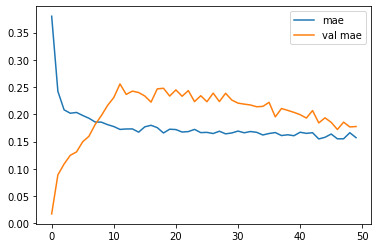

In [67]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [68]:
prediction2_a = forecast_predict(model2_a, test_gulpas_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_gulpas2_a = pd.DataFrame()
data_new_gulpas2_a['actual'] = x_test
data_new_gulpas2_a['prediction'] = data_result2_a
data_new_gulpas2_a.to_csv('gulpas_model3_adam-type1.csv')

data_new_gulpas2_a

131/131 [==============================] - 2s 6ms/step
575.1022 4.014112 634.59322601175


,actual,prediction
0,14250,14820.779297
1,14250,14796.551758
2,14200,14747.156250
3,14200,14748.056641
4,14200,14813.416016
...,...,...
229,14800,15949.195312
230,14750,15942.214844
231,15250,16007.832031
232,14350,15928.706055


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0194 - mae: 0.0859 - val_loss: 0.0117 - val_mae: 0.1050
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0187 - mae: 0.0817 - val_loss: 0.0014 - val_mae: 0.0310
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0170 - mae: 0.0780 - val_loss: 0.0024 - val_mae: 0.0427
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0167 - mae: 0.0778 - val_loss: 0.0013 - val_mae: 0.0285
Epoch 5/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0166 - mae: 0.0766 - val_loss: 0.0020 - val_mae: 0.0378
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0161 - mae: 0.0756 - val_loss: 0.0028 - val_mae: 0.0461
Epoch 7/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0173 - mae: 0.0772 - val_loss: 0.0023 - val_mae: 0.0411
Epoch 8/50
718/718 [==============================] - 5s 7ms/step - loss: 0.

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_gulpas_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_gulpas2_a1 = pd.DataFrame()
data_new_gulpas2_a1['actual'] = x_test
data_new_gulpas2_a1['prediction'] = data_result2_a1
data_new_gulpas2_a1.to_csv('gulpas_model3_adam-type2.csv')

plt.plot(y_test, data_new_gulpas2_a1.actual)
plt.plot(y_test, data_new_gulpas2_a1.prediction)
data_new_gulpas2_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 100, validation_data=val_step)

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

In [ ]:
win_size = 100
prediction2_a2 = forecast_predict(model2_a, test_gulpas_, time_size=win_size, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_gulpas2_a2 = pd.DataFrame()
data_new_gulpas2_a2['actual'] = x_test
data_new_gulpas2_a2['prediction'] = data_result2_a2
data_new_gulpas2_a2.to_csv('gulpas_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_gulpas2_a2.actual, '-o')
plt.plot(y_test,data_new_gulpas2_a2.prediction, '-o')
data_new_gulpas2_a2